This is the notebook for real backend submission.

In [1]:
import numpy as np
import math
from math import pi
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

from scipy.special import iv
from scipy.linalg import expm, block_diag
from scipy import integrate
from openfermion import fermi_hubbard, jordan_wigner, get_sparse_operator
from collections import Counter

from qiskit import QuantumCircuit, QuantumRegister
from qiskit import Aer, transpile
from qiskit.circuit import Parameter
from qiskit.providers.fake_provider import FakeGuadalupe, FakeNairobi
from qiskit.visualization import plot_histogram

from qiskit.tools import job_monitor

from HA_utils import Assembly_ACDF, get_real_CDF, get_fh_matrix

In [2]:
from qiskit import IBMQ

#IBMQ.save_account('')
IBMQ.load_account()
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')>,
 <AccountProvider for IBMQ(hub='qhack-event', group='main', project='level-1')>,
 <AccountProvider for IBMQ(hub='qhack-event', group='main', project='level-2-team-4')>]

In [3]:
def fh_evolution_para(N_sites, theta_para, gamma_para, step, to_gate=True):
    
    qr = QuantumRegister(2*N_sites,'qr')
    qc = QuantumCircuit(qr)
    
    for _ in range(step):
        
        ## Hopping terms 
        #theta = tau*t*j/step
        #theta = Parameter('theta')
        
        for i in range(N_sites//2):
            qc.rxx(theta_para,2*i,2*i+1)
            qc.ryy(theta_para,2*i,2*i+1)

            qc.rxx(theta_para,2*i+N_sites,2*i+1+N_sites)
            qc.ryy(theta_para,2*i+N_sites,2*i+1+N_sites)
            
        for i in range((N_sites-1)//2):
            qc.rxx(theta_para,2*i+1,2*i+2)
            qc.ryy(theta_para,2*i+1,2*i+2)

            qc.rxx(theta_para,2*i+N_sites+1,2*i+2+N_sites)
            qc.ryy(theta_para,2*i+N_sites+1,2*i+2+N_sites)
        
        ## Potential
        #gamma = tau*j*U/(2*step)
        #gamma = Parameter('gamma')
        
        for i in range(N_sites):
            qc.rzz(gamma_para,i,i+N_sites)
    return qc.to_gate() if to_gate else qc

def initial_state_prep(N_sites, initial_state_symmetry=True, to_gate=True):

    qr = QuantumRegister(2*N_sites,'q')
    qc = QuantumCircuit(qr)

    if initial_state_symmetry:
        qc.h(0)
        for i in range(N_sites):
            if i%2!=0:
                qc.x(i)
            else:
                qc.x(i+N_sites)

        qc.cnot(0,range(1,2*N_sites))

    else:
        for i in range(N_sites):
            if i%2!=0:
                qc.x(i)
            else:
                qc.x(i+N_sites)
        

    return qc.to_gate() if to_gate else qc

def get_new_Hadamard_circuit_para(N_sites, theta_para, gamma_para, step, initial_state_symmetry=True,test_type='real'):

    qr = QuantumRegister(2*N_sites+2,'q')
    qc = QuantumCircuit(qr)

    qc.h([0,1])
    if test_type=='real':
        pass
    elif test_type=='imag':
        qc.s(0)

    
    prep_gate = initial_state_prep(N_sites=N_sites,initial_state_symmetry=initial_state_symmetry)
    qc.append(prep_gate.control(), [0]+list(range(2,2*N_sites+2)))

    evolution_gate = fh_evolution_para(N_sites=N_sites, theta_para=theta_para, gamma_para=gamma_para, step=step)
    qc.append(evolution_gate,range(2,2*N_sites+2))

    prep_gate_conj = prep_gate.reverse_ops()
    qc.append(prep_gate_conj.control(), [1]+list(range(2,2*N_sites+2)))

    qc.h([0,1])

    qc.measure_all()

    return qc 

In [4]:
def prqs(random_number, extra_level): 
    
    extra_level = 2 * extra_level + 1
    qc = QuantumCircuit(2)
    pqrs_list = ['IIII','IXIX','IYZY','IZZZ','YIYX','YXYI','YYXZ','YZXY','XIXX','XXXI','XYYZ','XZYY','ZIZI','ZXZX','ZYIY','ZZIZ']
    if random_number == 0:
        qc.i(0)
        qc.i(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.i(0)
        qc.i(1)
    elif random_number == 1:
        qc.i(0)
        qc.x(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.i(0)
        qc.x(1)
    elif random_number == 2:
        qc.i(0)
        qc.y(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.z(0)
        qc.y(1)
    elif random_number == 3:
        qc.i(0)
        qc.z(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.z(0)
        qc.z(1)     
    elif random_number == 4:
        qc.y(0)
        qc.i(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.y(0)
        qc.x(1)   
    elif random_number == 5:
        qc.y(0)
        qc.x(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.y(0)
        qc.i(1)
    elif random_number == 6:
        qc.y(0)
        qc.y(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.x(0)
        qc.z(1)
    elif random_number == 7:
        qc.y(0)
        qc.z(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.x(0)
        qc.y(1)
    elif random_number == 8:
        qc.x(0)
        qc.i(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.x(0)
        qc.x(1)
    elif random_number == 9:
        qc.x(0)
        qc.x(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.x(0)
        qc.i(1)     
    elif random_number == 10:
        qc.x(0)
        qc.y(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.y(0)
        qc.z(1)   
    elif random_number == 11:
        qc.x(0)
        qc.z(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.y(0)
        qc.y(1)
    elif random_number == 12:
        qc.z(0)
        qc.i(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.z(0)
        qc.i(1)
    elif random_number == 13:
        qc.z(0)
        qc.x(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.z(0)
        qc.x(1)
    elif random_number == 14:
        qc.z(0)
        qc.y(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.i(0)
        qc.y(1)
    elif random_number == 15:
        qc.z(0)
        qc.z(1)
        for i in range(extra_level):
            qc.cnot(0,1)
        qc.i(0)
        qc.z(1)
    return qc

def error_mitigation(N_sites, trans_qc, extra_level):  #extra_level startz from 0. cnot_num = 2 * extra_level + 1
    
    num_qubits = trans_qc.num_qubits
    qc = QuantumCircuit(num_qubits, 2 * N_sites + 2)

    me = 0
    for gate_data in trans_qc.data:
        gate = gate_data[0]
        qubits = gate_data[1]
        if gate.name == 'cx':
            index = [qubits[0].index, qubits[1].index]
            random_num = np.random.randint(16)
            qc.append(prqs(random_num, extra_level), index) # random compiling with the 'random_num'-th random set and '2*extra_level' CNOTs
        elif gate.name == 'measure':
            qc.measure(qubits[0], [me])
            me = me + 1

        else:
            qc.append(gate_data)
    
    return qc

In [5]:
def get_circuit_list_to_run(N_sites,t,U,tau,step,shots_list,backend,extra_level,initial_state_symmetry=True):

    circ_list_real = []
    circ_list_imag = []
    theta = Parameter('theta')
    gamma = Parameter('gamma')
    circ_para_real = get_new_Hadamard_circuit_para(N_sites,theta_para=theta, gamma_para=gamma, step=step, initial_state_symmetry=initial_state_symmetry)
    circ_para_imag = get_new_Hadamard_circuit_para(N_sites,theta_para=theta, gamma_para=gamma, step=step, initial_state_symmetry=initial_state_symmetry,test_type='imag')

    circ_transpiled_real = transpile(circuits=circ_para_real, backend=backend, optimization_level=3)
    circ_transpiled_imag = transpile(circuits=circ_para_imag, backend=backend, optimization_level=3)

    circ_mitigated_real = error_mitigation(N_sites, circ_transpiled_real, extra_level=extra_level).decompose()
    circ_mitigated_imag = error_mitigation(N_sites, circ_transpiled_imag, extra_level=extra_level).decompose()

    circ_transpiled_mitigated_real = transpile(circuits=circ_mitigated_real, backend=backend, optimization_level=3)
    circ_transpiled_mitigated_imag = transpile(circuits=circ_mitigated_imag, backend=backend, optimization_level=3)
    for j, shot in enumerate(shots_list):

        if shot:
            theta_value = tau*t*(2*j+1)/step
            gamma_value = tau*U*(2*j+1)/(2*step)
            circ_binded_real = circ_transpiled_mitigated_real.bind_parameters({theta:theta_value,gamma:gamma_value})
            circ_binded_real.name = 'Re-circ-'+str(j)
            circ_list_real.append(circ_binded_real)

            circ_binded_imag = circ_transpiled_mitigated_imag.bind_parameters({theta:theta_value,gamma:gamma_value})
            circ_binded_imag.name = 'Im-circ-'+str(j)
            circ_list_imag.append(circ_binded_imag)
    return circ_list_real, circ_list_imag

In [6]:
def get_shots_per_run(F_list, total_shots,type='sample'):

    F_list_abs = np.array([np.abs(ele) for ele in F_list])
    probs = F_list_abs/sum(F_list_abs)
    if type=='sample':
        sampling = np.random.choice(range(len(probs)), size=int(total_shots), p=probs)
        counter = Counter(sampling)

        shots_list = np.zeros(len(probs),dtype=int)
        for i in range(len(probs)):
            shots_list[i] = int(counter[i])
    elif type=='distribution':
        shots_list = np.round(total_shots*probs)
    return shots_list

In [7]:
provider = IBMQ.get_provider(hub='qhack-event',project='level-2-team-4')  ## Guadelupe
backend = provider.get_backend('ibmq_guadalupe')

norm = np.linalg.norm(get_fh_matrix(N_sites=4, t=1, U=4))
tau = 3*np.pi/(4*norm)




In [ ]:
initial_state_symmetry = False
N_sites = 4
step = 2

F_list_import = np.load('F_list_d4e2_delta_4.npy')
shots_list = get_shots_per_run(F_list=F_list_import, total_shots=5e3, type='distribution')
#np.save('shots_list_submission0226', shots_list)


circ_list_raw = get_circuit_list_to_run(N_sites=N_sites,t=1,U=4,tau=tau,step=step,
                                        shots_list=shots_list,backend=backend,extra_level=0,initial_state_symmetry=initial_state_symmetry)

circ_list_extrapo1 = get_circuit_list_to_run(N_sites=N_sites,t=1,U=4,tau=tau,step=step,
                                        shots_list=shots_list,backend=backend,extra_level=1,initial_state_symmetry=initial_state_symmetry)

circ_list_extrapo2 = get_circuit_list_to_run(N_sites=N_sites,t=1,U=4,tau=tau,step=step,
                                        shots_list=shots_list,backend=backend,extra_level=2,initial_state_symmetry=initial_state_symmetry)

In [ ]:
#job_raw_real = backend.run(circ_list_raw[0],shots=1024, job_name='test-simulator-real')
#job_raw_imag = backend.run(circ_list_raw[1], shots=1024,job_name='test-simulator-imag')
# job_extrapo1_real = backend.run(circ_list_extrapo1[0], shots=1024, job_name='Ex1-Real-ASym-N=4-step=2')
# job_extrapo1_imag = backend.run(circ_list_extrapo1[1], shots=1024, job_name='Ex1-Imag-ASym-N=4-step=2')
# job_extrapo2_real = backend.run(circ_list_extrapo2[0], shots=1024, job_name='Ex2-Real-ASym-N=4-step=2')
# job_extrapo2_imag = backend.run(circ_list_extrapo2[1], shots=1024, job_name='Ex2-Imag-ASym-N=4-step=2')

In [13]:
def get_Z_list_from_job(job_real, job_imag):

    def calculate_Z(counts_real, counts_imag, N_sites):
        
        shots_real = counts_real.shots()

        p00, p01, p10, p11 = 0,0,0,0
        if ('0'*2*N_sites+'00') in counts_real.keys():
            p00 = counts_real['0'*2*N_sites+'00']/shots_real
        if ('0'*2*N_sites+'01') in counts_real.keys():
            p01 = counts_real['0'*2*N_sites+'01']/shots_real
        if ('0'*2*N_sites+'10') in counts_real.keys():
            p10 = counts_real['0'*2*N_sites+'10']/shots_real
        if ('0'*2*N_sites+'11') in counts_real.keys():
            p11 = counts_real['0'*2*N_sites+'11']/shots_real

        X = p00+p11-p01-p10

        shots_imag = counts_imag.shots()

        p00, p01, p10, p11 = 0,0,0,0
        if ('0'*2*N_sites+'00') in counts_imag.keys():
            p00 = counts_imag['0'*2*N_sites+'00']/shots_imag
        if ('0'*2*N_sites+'01') in counts_imag.keys():
            p01 = counts_imag['0'*2*N_sites+'01']/shots_imag
        if ('0'*2*N_sites+'10') in counts_imag.keys():
            p10 = counts_imag['0'*2*N_sites+'10']/shots_imag
        if ('0'*2*N_sites+'11') in counts_imag.keys():
            p11 = counts_imag['0'*2*N_sites+'11']/shots_imag

        Y = p00+p11-p01-p10

        #lambda_R = U/4*N_sites

        #Z = 2*(X-1j*Y)*np.exp(-1j*lambda_R*j*tau)
        Z = 2*(X-1j*Y)

        return Z
    
    
    res_real = job_real.result()
    res_imag = job_imag.result()

    L_real = len(res_real.results)
    L_imag = len(res_real.results)
    if L_real != L_imag:
        raise ValueError('Number of Experiments in job_real and job_imag is not the same!')
    L = L_real

    counts_real = [ res_real.get_counts(i) for i in range(L)]
    counts_imag = [ res_imag.get_counts(i) for i in range(L)]

    N_sites = len(res_real.results[0].header.clbit_labels)//2 -1
    Z_list = []

    for i in range(L):
        Z_list.append(calculate_Z(counts_real[i], counts_imag[i], N_sites=N_sites))

        
    

    return np.array(Z_list)

In [14]:
# N=4, Asym, extrapo = 0
job_real = backend.retrieve_job('63fb31d3dfd0c1bdfe0bfb80')
job_imag = backend.retrieve_job('63fb31d67ad0f9bdd0a7cbee')
# #tau = 0.011100302637884566 # N=6

# # N=4, Asym, extrapo = 1
job_real_1 = backend.retrieve_job('63fb31d9da181c44bed956b1')
job_imag_1 = backend.retrieve_job('63fb31dca8f65f72c0efda5a')

# # N=4, Asym, extrapo = 2
job_real_2 = backend.retrieve_job('63fb33857ad0f95128a7cbf8')
job_imag_2 = backend.retrieve_job('63fb3388d299e3cd504b3958')

# N=4, Asym, extrapo = 0, step=2
#job_real = backend.retrieve_job('63fb3df7da181c4d63d9570e')
#job_imag = backend.retrieve_job('63fb3e00a29ce1256c8bd0a2')
#tau = 0.011100302637884566


#tau = 0.055659863049549646
F_list_400 = np.load('F_list/F_list_d4e2_delta_4.npy')

Z_list = get_Z_list_from_job(job_real=job_real, job_imag = job_imag)
Z_list_1 = get_Z_list_from_job(job_real=job_real_1, job_imag = job_imag_1)
Z_list_2 = get_Z_list_from_job(job_real=job_real_2, job_imag=job_imag_2)

/Users/dranz/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'N_sites=4, ibm_guadalupe')

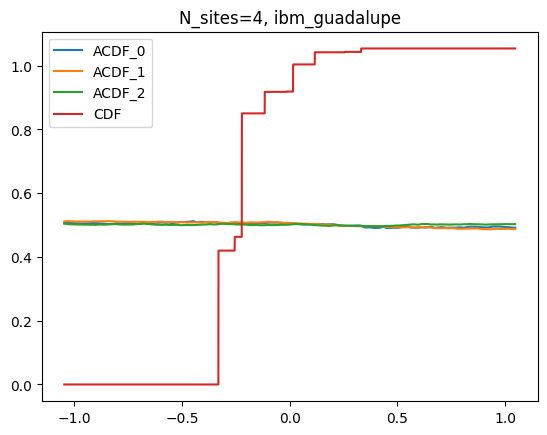

In [19]:
x_list = np.linspace(-pi/3,pi/3,10000)
ACDF_0 = Assembly_ACDF(Z_list=Z_list,F_list=F_list_400[0:len(Z_list)],precision=10000)
ACDF_1 = Assembly_ACDF(Z_list=Z_list_1,F_list=F_list_400[0:len(Z_list)],precision=10000)
ACDF_2 = Assembly_ACDF(Z_list=Z_list_2,F_list=F_list_400[0:len(Z_list)],precision=10000)

plt.plot(x_list, ACDF_0,label='ACDF_0')
plt.plot(x_list, ACDF_1,label='ACDF_1')
plt.plot(x_list, ACDF_2,label='ACDF_2')
plt.plot(x_list, get_real_CDF(N_sites=4, t=1, U=4, tau=tau, precision=10000),label='CDF')
plt.legend()
plt.title('N_sites=4, ibm_guadalupe')

In [12]:
Z_list[0].conj()

AttributeError: 'complex' object has no attribute 'conj'